
### Simple EDA & Preprocessing

Let's have a look at the dataset. The dataset contains heroes and comics, and the relationship between them. The dataset is divided into three files:

- **nodes.csv:** Contains two columns (node, type), indicating the name and the type (comic, hero) of the nodes.
- **edges.csv:** Contains two columns (hero, comic), indicating in which comics the heroes appear.
- **hero-network.csv:** Contains the network of heroes which appear together in the comics. This file was originally taken from 

What about the data?

In all the files, ther hero names are only 20 characters. All names higher than 20, are truncated. Furthermore, some heroes have the symbol "/" after their name. That should be  their secret identity. Considering that there are a lot of heroes, let's select the most known. We are going to choose the first 50, depending on the number of comics they appear

In [201]:
import pandas as pd
import os
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt

In [180]:
# list of heroes, without repetitions

# Read the CSV file
# nodes_data = pd.read_csv("dataset/nodes.csv")
edges_data = pd.read_csv("dataset/edges.csv")
heroes_network_data = pd.read_csv("dataset/hero-network.csv")

### Retrieveing the most famous heroes

We define the most famous hero as the one that appears in more comics.

The edge_data dataset contains in which comic an hero appeares. So, let's count the number of appearances of each hero, in order to understand who are the more famous.

In [185]:
# Count the appearances of each hero
hero_counts = edges_data['hero'].value_counts()
hero_counts

hero
SPIDER-MAN/PETER PARKER    1577
CAPTAIN AMERICA            1334
IRON MAN/TONY STARK        1150
THING/BENJAMIN J. GR        963
THOR/DR. DONALD BLAK        956
                           ... 
PROGENITOR                    1
DOMANI, DINO                  1
DOGGEREL                      1
DOCTOR, DR. JOSHUA            1
24-HOUR MAN/EMMANUEL          1
Name: count, Length: 6439, dtype: int64

Select the first 25 most famous heroes, according to the rank printed above.

In [186]:
hero_selection_number = 25

# Extract the first 25 hero names
heroes = hero_counts.head(hero_selection_number).index.tolist()

# Display the first 25 heroes
print(heroes)

['SPIDER-MAN/PETER PARKER', 'CAPTAIN AMERICA', 'IRON MAN/TONY STARK', 'THING/BENJAMIN J. GR', 'THOR/DR. DONALD BLAK', 'HUMAN TORCH/JOHNNY S', 'MR. FANTASTIC/REED R', 'HULK/DR. ROBERT BRUC', 'WOLVERINE/LOGAN', 'INVISIBLE WOMAN/SUE', 'SCARLET WITCH/WANDA', 'BEAST/HENRY &HANK& P', 'DR. STRANGE/STEPHEN', 'WATSON-PARKER, MARY', 'DAREDEVIL/MATT MURDO', 'HAWK', 'VISION', 'CYCLOPS/SCOTT SUMMER', 'WASP/JANET VAN DYNE', 'JAMESON, J. JONAH', 'ANT-MAN/DR. HENRY J.', 'SUB-MARINER/NAMOR MA', 'STORM/ORORO MUNROE S', 'PROFESSOR X/CHARLES', 'FURY, COL. NICHOLAS']


in hero-network.csv file, ther hero names are only 20 characters or lower. All names higher than 20, are truncated. Furthermore, some heroes have the symbol "/" after their name. The right part after the "/" should be their secret identity. Let's truncate the heros' name in heroes list, according to the dataset file, and let's remove the secret identity of a hero. We do the same also with heroes_network dataset

In [189]:
heroes = [heroes[i][:20].split('/')[0] for i in range(len(heroes))]
for c in ['hero1', 'hero2']:
    heroes_network_data[c] = heroes_network_data[c].apply(lambda x : x[:20].split("/")[0])

# print(heroes)
# heroes_network_data

We are going to create a new dataset, with the purpose of reporting all the appearance  of two heroes together. The new dataset is composed by three columns, and every hero is combined with all the others. The total number of heroes combined each other is 25, the 25 most known heroes selected before:

- **Hero1:** name of hero 1;
- **Hero2:** name of hero 2;
- **Appeared_Together:** Number of times they appeared together.

In [195]:
file = './backups/network_df.csv'
# Ff the backup file exists, read it as pandas dataframe
if os.path.exists(file):
    network_df = pd.read_csv(file)
else:
    # the backup file does not exist. Let's create the dataset combining all the heroes
    list_heroes_1 = []
    list_heroes_2 = []
    list_appear_together = []

    for i in range(len(heroes)):
        for j in range(i+1, len(heroes)):
            list_heroes_1.append(heroes[i])
            list_heroes_2.append(heroes[j])
            # counting af appearances of the two heroes, also switching the order where they are written
            appear_together = len(heroes_network_data[(heroes_network_data['hero1']==heroes[i])&(heroes_network_data['hero2']==heroes[j])])
            appear_together += len(heroes_network_data[(heroes_network_data['hero1']==heroes[j])&(heroes_network_data['hero2']==heroes[i])])
            list_appear_together.append(appear_together)
    # new dataframe creation
    network_df = pd.DataFrame({'Hero1':list_heroes_1, 'Hero2':list_heroes_2, 'Appeared_Together':list_appear_together})

    # Dataset storage into a file, in order to speed up the process during the next execution
    filepath = Path(file)  
    network_df.to_csv(filepath, index=False)  

display(network_df.head())

,Hero1,Hero2,Appeared_Together
0,SPIDER-MAN,CAPTAIN AMERICA,145
1,SPIDER-MAN,IRON MAN,94
2,SPIDER-MAN,THING,126
3,SPIDER-MAN,THOR,95
4,SPIDER-MAN,HUMAN TORCH,147


Sorting the heroes relation in descending order, based on the *Appeared_Together* value

In [196]:
network_df = network_df.sort_values('Appeared_Together', ascending=False)
display(network_df)

,Hero1,Hero2,Appeared_Together
70,THING,HUMAN TORCH,744
110,HUMAN TORCH,MR. FANTASTIC,713
71,THING,MR. FANTASTIC,708
131,MR. FANTASTIC,INVISIBLE WOMAN,701
113,HUMAN TORCH,INVISIBLE WOMAN,694
...,...,...,...
60,IRON MAN,VISION,0
213,BEAST,VISION,0
68,IRON MAN,"FURY, COL. NICHOLAS",0
210,BEAST,"WATSON-PARKER, MARY",0


### Graph creation

Indirect graph, according to the following schema:
- **Nodes:** heroes.
- **Edges:** appearance of two heroes in the same comic. The edge will be weighted depending on the number of appearances.

As we can notice by the dataset representation above, there are some heroes that never appeared together. In those cases, there won't be any edge. As a consequence, if a hero is not linked to any of the others, it will not be inserted into the graph.

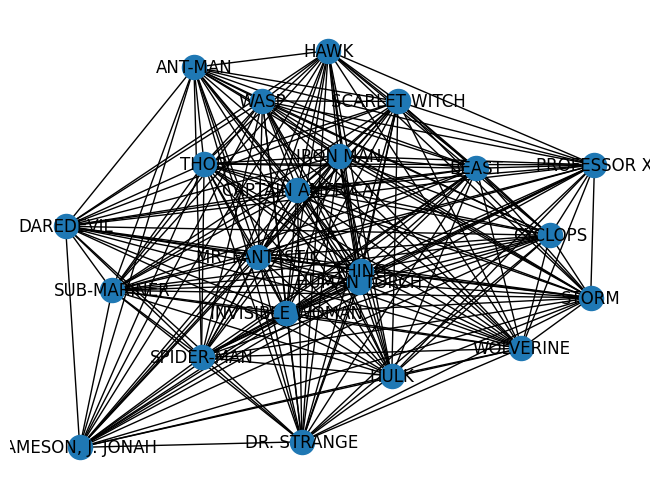

In [202]:
# Graph creation
G = nx.Graph()

for hero1, hero2, weight in network_df.values.tolist():
    # Checking if the weight (number of appearances) is not 0
    if int(weight) != 0:
        G.add_edge(hero1, hero2, weight=weight)

# Graph representation
nx.draw(G, with_labels=True)
plt.show()

Graph formatting, in order to make it more readable

In [158]:
degree_centrality = nx.degree_centrality(G)
degree_centrality

{'THING': 0.9893617021276595,
 'HUMAN TORCH': 1.0,
 'MR. FANTASTIC': 1.0,
 'INVISIBLE WOMAN': 0.9893617021276595,
 'SPIDER-MAN': 0.9893617021276595,
 'JAMESON, J. JONAH': 0.9042553191489362,
 'CAPTAIN AMERICA': 1.0,
 'IRON MAN': 0.9787234042553191,
 'WASP': 0.9787234042553191,
 'ANT-MAN': 0.9361702127659575,
 'CYCLOPS': 1.0,
 'MARVEL GIRL': 0.9361702127659575,
 'WOLVERINE': 1.0,
 'STORM': 0.9787234042553191,
 'THOR': 0.9787234042553191,
 'PARKER, MAY': 0.648936170212766,
 'SCARLET WITCH': 0.9787234042553191,
 'ROBERTSON, JOE': 0.7872340425531915,
 'COLOSSUS II': 0.9361702127659575,
 'ANGEL': 0.9787234042553191,
 'ICEMAN': 0.9574468085106382,
 'HAWK': 0.925531914893617,
 'BEAST': 0.9787234042553191,
 'PROFESSOR X': 0.8936170212765957,
 'NIGHTCRAWLER': 0.8829787234042553,
 'SHADOWCAT': 0.776595744680851,
 'ODIN [ASGARDIAN]': 0.6808510638297872,
 'DAREDEVIL': 0.9574468085106382,
 'NELSON, FRANKLIN FOG': 0.7446808510638298,
 'WONDER MAN': 0.9468085106382979,
 'HULK': 0.9468085106382979,
 '

In [162]:
G['SPIDER-MAN']

AtlasView({'JAMESON, J. JONAH': {'weight': 526}, 'PARKER, MAY': {'weight': 380}, 'ROBERTSON, JOE': {'weight': 356}, 'LEEDS, BETTY BRANT': {'weight': 249}, 'THOMPSON, EUGENE FLA': {'weight': 240}, 'OSBORN, HARRY': {'weight': 181}, 'HUMAN TORCH': {'weight': 147}, 'CAPTAIN AMERICA': {'weight': 145}, 'THING': {'weight': 126}, 'MR. FANTASTIC': {'weight': 121}, 'DAREDEVIL': {'weight': 103}, 'KINGPIN': {'weight': 102}, 'SPIDER-MAN CLONE': {'weight': 98}, 'INVISIBLE WOMAN': {'weight': 97}, 'THOR': {'weight': 95}, 'IRON MAN': {'weight': 94}, 'HULK': {'weight': 93}, 'WASP': {'weight': 78}, 'DR. STRANGE': {'weight': 71}, 'SCARLET WITCH': {'weight': 67}, 'WOLVERINE': {'weight': 63}, 'SHE-HULK': {'weight': 58}, 'HAWK': {'weight': 57}, 'CYCLOPS': {'weight': 51}, 'BEAST': {'weight': 51}, 'ANT-MAN': {'weight': 46}, 'SUB-MARINER': {'weight': 46}, 'COLOSSUS II': {'weight': 45}, 'DR. DOOM': {'weight': 44}, 'PUNISHER II': {'weight': 43}, 'STORM': {'weight': 42}, 'PROFESSOR X': {'weight': 41}, 'BLACK WIDOW

In [118]:
betweenness_centrality = nx.betweenness_centrality(G)
betweenness_centrality

{'THING': 0.0,
 'HUMAN TORCH': 0.0,
 'MR. FANTASTIC': 0.0,
 'INVISIBLE WOMAN': 0.0,
 'SPIDER-MAN': 0.0049261083743842365,
 'JAMESON, J. JONAH': 0.0,
 'CAPTAIN AMERICA': 0.006978653530377668,
 'IRON MAN': 0.006978653530377668,
 'WASP': 0.0012315270935960591,
 'ANT-MAN': 0.0,
 'CYCLOPS': 0.06198686371100164,
 'MARVEL GIRL': 0.0,
 'WOLVERINE': 0.036535303776683084,
 'STORM': 0.013136288998357962,
 'THOR': 0.017241379310344827,
 'PARKER, MAY': 0.0,
 'SCARLET WITCH': 0.020525451559934314,
 'ROBERTSON, JOE': 0.0,
 'COLOSSUS II': 0.004105090311986863,
 'ANGEL': 0.0,
 'ICEMAN': 0.0,
 'HAWK': 0.0012315270935960591,
 'BEAST': 0.0,
 'PROFESSOR X': 0.0,
 'NIGHTCRAWLER': 0.022167487684729065,
 'SHADOWCAT': 0.0,
 'ODIN [ASGARDIAN]': 0.0,
 'WONDER MAN': 0.0,
 'DAREDEVIL': 0.0,
 'NELSON, FRANKLIN FOG': 0.0}

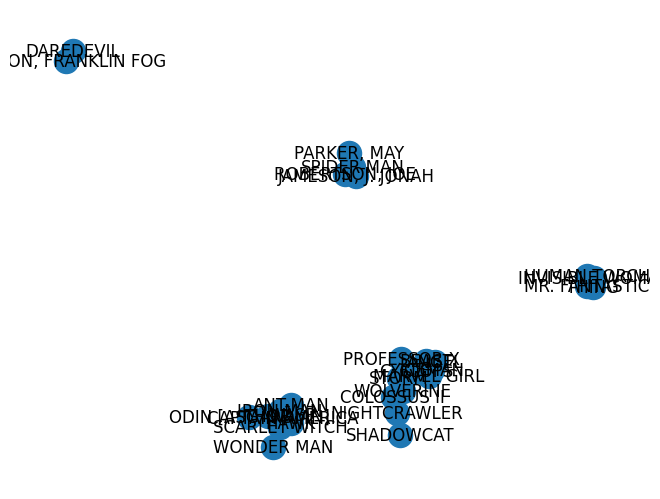

In [116]:
nx.draw(G, with_labels=True)
plt.show()

In [117]:
closeness_centrality = nx.closeness_centrality(G)
closeness_centrality

{'THING': 0.10344827586206896,
 'HUMAN TORCH': 0.10344827586206896,
 'MR. FANTASTIC': 0.10344827586206896,
 'INVISIBLE WOMAN': 0.10344827586206896,
 'SPIDER-MAN': 0.10344827586206896,
 'JAMESON, J. JONAH': 0.07758620689655173,
 'CAPTAIN AMERICA': 0.2206896551724138,
 'IRON MAN': 0.2206896551724138,
 'WASP': 0.1839080459770115,
 'ANT-MAN': 0.15763546798029557,
 'CYCLOPS': 0.24630541871921185,
 'MARVEL GIRL': 0.1724137931034483,
 'WOLVERINE': 0.21551724137931036,
 'STORM': 0.20283975659229211,
 'THOR': 0.1839080459770115,
 'PARKER, MAY': 0.06206896551724138,
 'SCARLET WITCH': 0.2206896551724138,
 'ROBERTSON, JOE': 0.07758620689655173,
 'COLOSSUS II': 0.16420361247947454,
 'ANGEL': 0.1724137931034483,
 'ICEMAN': 0.1724137931034483,
 'HAWK': 0.1839080459770115,
 'BEAST': 0.1724137931034483,
 'PROFESSOR X': 0.16420361247947454,
 'NIGHTCRAWLER': 0.15673981191222572,
 'SHADOWCAT': 0.11123470522803115,
 'ODIN [ASGARDIAN]': 0.1161524500907441,
 'WONDER MAN': 0.12981744421906694,
 'DAREDEVIL': 0

In [124]:
import scipy
pagerank_centrality = nx.pagerank(G)
pagerank_centrality

{'THING': 0.033415715374517804,
 'HUMAN TORCH': 0.03384857911713443,
 'MR. FANTASTIC': 0.033445216544783885,
 'INVISIBLE WOMAN': 0.03262382229689717,
 'SPIDER-MAN': 0.052713052296993954,
 'JAMESON, J. JONAH': 0.03423741643548126,
 'CAPTAIN AMERICA': 0.050400967192281626,
 'IRON MAN': 0.04706886965761145,
 'WASP': 0.03759599554107121,
 'ANT-MAN': 0.029585997550212854,
 'CYCLOPS': 0.057103028022664426,
 'MARVEL GIRL': 0.03420514245143769,
 'WOLVERINE': 0.03951673995557016,
 'STORM': 0.03831643954109369,
 'THOR': 0.03407751080338815,
 'PARKER, MAY': 0.01849277279613784,
 'SCARLET WITCH': 0.045685482121584464,
 'ROBERTSON, JOE': 0.027890091804720293,
 'COLOSSUS II': 0.032661507899582366,
 'ANGEL': 0.0325986751291708,
 'ICEMAN': 0.03353130554665587,
 'HAWK': 0.03389789917728092,
 'BEAST': 0.033297196286672784,
 'PROFESSOR X': 0.018742951578319157,
 'NIGHTCRAWLER': 0.03264143808712214,
 'SHADOWCAT': 0.014052242168377688,
 'ODIN [ASGARDIAN]': 0.011163940669538137,
 'WONDER MAN': 0.01052333728

In [127]:
G['SPIDER-MAN']

AtlasView({'JAMESON, J. JONAH': {'weight': 526}, 'PARKER, MAY': {'weight': 380}, 'ROBERTSON, JOE': {'weight': 356}})

In [126]:
G['MR. FANTASTIC']

AtlasView({'HUMAN TORCH': {'weight': 713}, 'THING': {'weight': 708}, 'INVISIBLE WOMAN': {'weight': 701}})